## Introduction

Below we will be working with a dataset of video game sales for the hypothetical distribution company Ice. Our task is to make conclusions about sales data ranging from 1985 to 2016 to model sales trends for 2017 and beyond. We will begin by sanitizing and organizing the data before doing some preliminary exploratory data analysis. Then we will test some hypotheses and conclude with some theories about user score statistics.

## Initializing

In [1]:
# Loading all the libraries
import pandas as pd
from scipy import stats as st
import numpy as np

# Graphing libraries
import plotly.express as px
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter as pf

In [2]:
# Read the csv into dataframe
df_raw = pd.read_csv('./datasets/games.csv')

In [3]:
# Quick view
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# Display percentage of missing values per column
missing_values = df_raw.isnull().sum().to_frame('missing_values')
missing_values['%'] = round(df_raw.isnull().sum()*100/len(df_raw),2)
missing_values.sort_values(by='%', ascending=False)

print('Missing column values -- by percentage of rows:')
display(missing_values)

Missing column values -- by percentage of rows:


,missing_values,%
Name,2,0.01
Platform,0,0.00
Year_of_Release,269,1.61
Genre,2,0.01
NA_sales,0,0.00
EU_sales,0,0.00
JP_sales,0,0.00
Other_sales,0,0.00
Critic_Score,8578,51.32
User_Score,6701,40.09


### Clean the Dataframe

Based on the call to `info()` above we see some items needing sanitizing. 

First and foremost, there are two titles with no name or genre data. These are unusable and since they constitute a fraction of the data, we can simply drop them.

We should fill the missing values for 'year_of_release,' 'critic_score,' and 'user_score' with representative values (medians). They are quantitative columns and thus shouldn't have missing values if we can help it. However, it would be easy to skew the data filling such diverse data with simple medians. To avoid this, we will first group games by platform and replace missing values for 'year_of_release' with the median year of release for the game's platform. Then we will group games by genre and replace missing values for 'critic_score' and 'user_score' with median scores for the game's genre.

Finally, the 'rating' column is meant to be all strings, and we can interpret missing values as having not received a rating by the ESRB. This is an important metric and shuold not be ignored, and since it is a qualitative column, we can simply categorize all missing entries as 'None.'

We will also add a 'total_sales' column defined as the sum of all regions' sales for ease of calculation later.

In [5]:
# Rename columns
df_raw.rename(str.lower, axis='columns', inplace=True)

# Delete rows with no name or genre (only 2 titles out of 16715)
df_raw.dropna(subset=['name'], inplace=True)

# Replace NaNs of 'year_of_release' with median representative value grouped by platform. Cast to int64
year_median_by_platform = df_raw.groupby('platform')['year_of_release'].median()

for platform in year_median_by_platform.index:
    df_raw['year_of_release'] = df_raw['year_of_release'].where((df_raw['platform'] != platform) | (~df_raw['year_of_release'].isna()), year_median_by_platform[platform])
    
# There is an erroneous entry for the DS whose year_of_release should also be replaced with the median year for the DS
df_raw.loc[15957, 'year_of_release'] = year_median_by_platform['DS']
df_raw['year_of_release'] = df_raw['year_of_release'].astype('int64')

# Replace NaNs of 'critic_score' with median representative value grouped by genre. Cast to int64
cscore_median_by_genre = df_raw.groupby('genre')['critic_score'].median()
for genre in cscore_median_by_genre.index:
    df_raw['critic_score'] = df_raw['critic_score'].where((df_raw['genre'] != genre) | (~df_raw['critic_score'].isna()), cscore_median_by_genre[genre])
df_raw['critic_score'] = df_raw['critic_score'].astype('int64')

# The 'user_score' column is type object (string). First, we replace 'tbd' values with nans.
# Replace NaNs of 'user_score' with median representative value grouped by genre. Values are decimal so won't cast to int64
df_raw['user_score'] = df_raw['user_score'].replace('tbd', 'nan')
df_raw['user_score'] = df_raw['user_score'].astype('float')
uscore_median_by_genre = df_raw.groupby('genre')['user_score'].median()
for genre in uscore_median_by_genre.index:
    df_raw['user_score'] = df_raw['user_score'].where((df_raw['genre'] != genre) | (~df_raw['user_score'].isna()), uscore_median_by_genre[genre])
    
# Replace NaNs of 'rating' with 'None' string so we may cast to string
df_raw['rating'] = df_raw['rating'].fillna('None')
df_raw['rating'] = df_raw['rating'].astype('str')

# Calculate total sales
df_raw['total_sales'] = df_raw.loc[:,['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1, min_count=1)

# Confirm no NaNs and new column types
df_raw.info()
display(df_raw.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int64  
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.2+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15238,Catan,DS,2009,Strategy,0.00,0.02,0.00,0.00,73,7.8,None,0.02
2786,Madagascar: Escape 2 Africa,DS,2008,Action,0.41,0.25,0.00,0.07,55,7.4,E,0.73
7730,Parlor! Mini 4,SNES,1996,Misc,0.00,0.00,0.19,0.00,69,7.1,None,0.19
5948,Guardian Heroes,SAT,1995,Role-Playing,0.00,0.00,0.29,0.00,74,7.8,None,0.29
13884,SWAT: Target Liberty,PSP,2007,Shooter,0.03,0.00,0.00,0.00,50,7.7,T,0.03
5289,One Piece: Gigant Battle 2 Shin Sekai,DS,2011,Fighting,0.00,0.00,0.35,0.00,72,7.6,None,0.35
2813,Just Dance 2015,WiiU,2014,Misc,0.38,0.29,0.00,0.06,75,6.6,E10+,0.73
15808,East India Company,PC,2009,Strategy,0.01,0.00,0.00,0.00,67,5.7,T,0.01
12539,Digimon All-Star Rumble,X360,2014,Fighting,0.05,0.01,0.00,0.01,72,5.7,E10+,0.07
12822,Ride to Hell,X360,2013,Racing,0.04,0.01,0.00,0.01,19,1.3,M,0.06


## Platform Performance Analysis

### Top Five Platforms of All Time

We will now look at the performances of past gaming platforms to isolate the most relevant years to continue to look at. We care about the life cycle of a platform -- its rise, its popular years, and its fall. First, we will look at the life cycle of the top five video game platforms of all time, and then leverage this information analyzing the platforms of 2016.

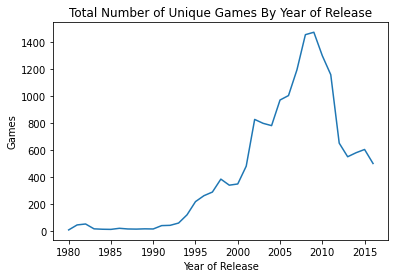

In [6]:
# Games released per year simple plot
df_raw.groupby('year_of_release')['name'].count().plot()
plt.title('Total Number of Unique Games By Year of Release')
plt.ylabel('Games')
plt.xlabel('Year of Release')
plt.show()

Games released really make a leap around the millennium, especially in conjunction with the rise of the PS2, the top-selling platform of all time. Sales peak in 2008, and much like the millenium peak, this too could be driven by particular platforms. We should turn our attention to the popularity of top platforms over the years.

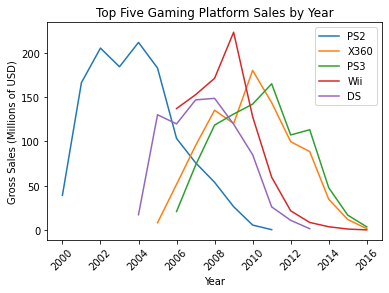

In [7]:
# Determine the top five most popular platforms
top_five_platforms = list(df_raw.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index)
df_topfive = df_raw.query("platform in @top_five_platforms")

# Graph total sales over the years with legend
fig, ax = plt.subplots()
ax.clear()
for platform in top_five_platforms:
    ax.plot(df_topfive.query('platform == @platform').groupby('year_of_release')['total_sales'].sum())

plt.legend(top_five_platforms)
plt.ylabel('Gross Sales (Millions of USD)')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title('Top Five Gaming Platform Sales by Year')
plt.show()

It seems the peak in 2008-2009 is driven by four out of the top five platforms of all time performing exceptionally well at the same time.

Truly exceptional platforms have peak sales for about 5 to 6 good years before dropping off. We should figure out some basic temporal metrics describing where a platform is in this life cycle. We'll create a function that does just this for us, and look at what these metrics look like for the top five platforms of all time:

In [8]:
'''
New dataframe for the top five platforms' temporal performance metrics:
    'platform': The platform in question    
    'intro_year': The year the first sales for this platform occurred
    'first_perc_year': The earliest year in which sales exceed the threshold percentile (usu. 50%) of peak sales
    'peak_year': The year of highest gross sales for this platform
    'last_perc_year': The latest year in which the sales exceed the threshold percentile (usu. 50%) of peak sales; NaN if no valid year
    'drop_year': The earliest year after peak sales in which sales were lower than 5% of peak sales; NaN if no valid year
    'unique_titles': The total number of unique titles in the sales data for this platform
    'total_sales': The total sales across all years for this platform
'''

data = []
thresh_percentile = 0.5
dropoff_percentile = 0.05
cols = ['platform', 'intro_year', 'first_perc_year', 'peak_year', 'last_perc_year', 'drop_year', 'unique_titles', 'total_sales']

def row_creator_fun(dframe, platform):
    platform_sales_df = dframe.query('platform == @platform').groupby('year_of_release')['total_sales'].sum().reset_index()
    max_sales = platform_sales_df['total_sales'].max()
    peak_year = platform_sales_df.query('total_sales == @max_sales')['year_of_release'].min()
    
    # Calculate relevant years of performance indicators for the platforms and return a row
    return [
        platform, # platform
        platform_sales_df['year_of_release'].min(), # first_year
        platform_sales_df.query('total_sales > (@thresh_percentile * @max_sales) and year_of_release <= @peak_year')['year_of_release'].min(), # first_perc_year
        peak_year, # peak_year
        platform_sales_df.query('total_sales > (@thresh_percentile * @max_sales) and year_of_release >= @peak_year')['year_of_release'].max(), # last_perc_year
        platform_sales_df.query('total_sales <= (@dropoff_percentile * @max_sales) and year_of_release >= @peak_year')['year_of_release'].min(), # drop_year
        dframe.query('platform == @platform')['name'].count(), # unique_titles
        platform_sales_df['total_sales'].sum() #total_sales
    ]

for platform in top_five_platforms:
    data.append(row_creator_fun(df_topfive, platform))
top_five_metrics = pd.DataFrame(data, columns=cols)
display(top_five_metrics)

,platform,intro_year,first_perc_year,peak_year,last_perc_year,drop_year,unique_titles,total_sales
0,PS2,2000,2001,2004,2005,2010,2161,1255.77
1,X360,2005,2007,2010,2012,2016,1262,971.42
2,PS3,2006,2008,2011,2013,2016,1331,939.65
3,Wii,2006,2006,2009,2010,2013,1320,907.51
4,DS,2004,2005,2008,2010,2013,2151,806.12


The time period to invest in a top-performing platform is, on average, 6 to 8 years, beginning with its inception. After this point, the yearly gross sales are below 50% of their peak sales and it is time to invest in a new platform. Furthermore, a peak performance year actually tends to signal a forecoming dropoff: after a platform has hit its peak, within two years it will drop to below 50% of peak sales.

### Modern platforms

We would like to filter the data for the rest of our analysis to only include relevant years for top-performing platforms in the current era. After all, we want to model for the immediate future, and so are less interested in far-past data. For 2016 we will calculate the top ten grossing platforms and trace back their starting years to determine how far back our data should continue to reach.

In [9]:
# Calculate top ten performing platforms in 2016
top_ten_2016_series = df_raw.query('year_of_release == 2016').groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10)
display(top_ten_2016_series)
top_ten_2016_platforms = top_ten_2016_series.index

# Use above metrics function to determine where in their life cycle the platforms are
data = []
for platform in top_ten_2016_platforms:
    data.append(row_creator_fun(df_raw, platform))
top_2016_df = pd.DataFrame(data, columns=cols)
display(top_2016_df)

platform
PS4     69.25
XOne    26.15
3DS     15.14
PC       5.25
WiiU     4.60
PSV      4.25
PS3      3.60
X360     1.52
Wii      0.18
Name: total_sales, dtype: float64

,platform,intro_year,first_perc_year,peak_year,last_perc_year,drop_year,unique_titles,total_sales
0,PS4,2013,2014,2015,2016,NaN,392,314.14
1,XOne,2013,2014,2015,2015,NaN,247,159.32
2,3DS,2011,2011,2011,2014,NaN,520,259.00
3,PC,1985,2010,2011,2012,NaN,974,259.52
4,WiiU,2012,2012,2014,2015,NaN,147,82.19
5,PSV,2011,2012,2012,2014,NaN,430,54.07
6,PS3,2006,2008,2011,2013,2016.0,1331,939.65
7,X360,2005,2007,2010,2012,2016.0,1262,971.42
8,Wii,2006,2006,2009,2010,2013.0,1320,907.51


It turns out there are only nine platforms with new title releases in 2016. We may isolate three of these platforms with sales in 2016 which are nonetheless irrelevant: the PS3, X360, and Wii platforms all have 2016 sales below 5% of their peak sales. We may remove these from our new dataframe, as well as the 'drop_year' column, which has become irrelevant for the six remaining well-performing platforms of 2016.

A quick note that the PC is an exceptional platform due to its continually-evolving nature. While the generations of platforms such as the Playstation get rebranded and emblazoned with new titles every six or so years, every successive operating system in PC still gets lumped under the name "PC" for the sake of sales data. We shouldn't be looking at 1985 data for the PC if sales didn't even reach half of their peak until 2010. We should therefore find a different value for 'intro_year.' The operating system that would have been active during 2010-2012, the primary booming years of PC sales, was Windows 7, which was released in 2009, so we should replace the 'intro_year' of PC with 2009:

In [10]:
# Drop the rows containing data for the PS3, X360, and Wii platforms
top_2016_df.drop(top_2016_df.index[[6, 7, 8]], inplace=True)
top_2016_df.drop('drop_year', axis=1, inplace=True)

# Introduction year of Windows 7 is a more reasonable start year for modern data regarding PC sales
top_2016_df['intro_year'] = top_2016_df['intro_year'].replace(1985, 2009)

The earliest year of sales with these six platforms is 2009. Now that we will move into analyzing these six platforms and their games more in depth, we should isolate the main dataset dataframe to only sales after 2009.

In [11]:
# Cut out all rows containing years less than 2012
df = df_raw[df_raw['year_of_release'] >= 2012]
display(df.sample(10))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15483,RollerCoaster Tycoon World,PC,2016,Simulation,0.00,0.02,0.00,0.00,43,2.4,E,0.02
15911,Psychedelica of the Black Butterfly,PSV,2015,Action,0.00,0.00,0.02,0.00,68,7.4,None,0.02
11641,Major League Baseball 2K12,DS,2012,Sports,0.07,0.00,0.00,0.01,75,7.4,E,0.08
14025,Super Hero Generation,PSV,2014,Role-Playing,0.00,0.00,0.04,0.00,74,7.8,None,0.04
6955,NBA Live 15,PS4,2014,Sports,0.16,0.04,0.00,0.04,59,5.6,E,0.24
16447,The Train Giant,PC,2012,Strategy,0.00,0.01,0.00,0.00,73,7.8,None,0.01
15086,Cross Ange: Tenshi to Ryuu no Rondo tr.,PSV,2015,Action,0.00,0.00,0.02,0.00,68,7.4,None,0.02
3593,Yokai Sangokushi,3DS,2016,Action,0.00,0.00,0.56,0.00,68,7.4,None,0.56
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,69,7.1,None,0.01
9949,Reality Fighters,PSV,2012,Fighting,0.05,0.05,0.00,0.02,54,3.8,T,0.12


We can take a quick look at these six platforms graphically in much the same way we looked at the top five platforms of all time:

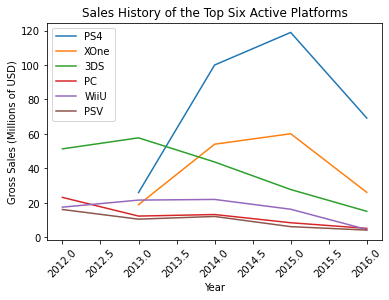

In [12]:
# Graph total sales over the years with legend
fig, ax = plt.subplots()
ax.clear()
for platform in top_2016_df['platform']:
    ax.plot(df.query('platform == @platform').groupby('year_of_release')['total_sales'].sum())

plt.legend(top_2016_df['platform'])
plt.ylabel('Gross Sales (Millions of USD)')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title('Sales History of the Top Six Active Platforms')
plt.show()

We should recall the timeline of a popular platform: the data supported 6 to 8 years of sales performance from a popular platform. Of the above platforms, the PS4, XOne, and WiiU are the only platforms matching the criteria of not yet having reached the 6 to 8 year window. Relative to the other platforms mentioned, though, the WiiU does not have a large international market share.

We do of course see a downward trend for 2016 for every platform. This matters less for newer platforms. After all, the DS, X360, and PS2 all had drops in sales before their peak years (see graph from Section 3.1), so even the top five most-popular platforms are not immune to early lagging sales. We should, however, be concerned about the PSV and 3DS.

As always, the PC is nebulous, as it is a platform that remains accessible to most households looking to buy video games and will not disappear as a platform as it continues to evolve new OSs under the same "PC" umbrella. It has sales data dating back to 1985, and will continue to have moderate sales data for the foreseeable future.

In conclusion from the above considerations, if defining a profitable platform as "a platform which is not projected to drop below 5% of its peak annual sales in the next two years," then the PS4, XOne, WiiU, and PC platforms are all profitable to market.

## Games Sales

### Individual Game Sales Distributions by Platform
Now that we have isolated the relevant years of analysis for modern platforms active in 2016, we can look at the latest sales, rating, and genre data for each game. We will start with looking at game sales broadly, by platform.

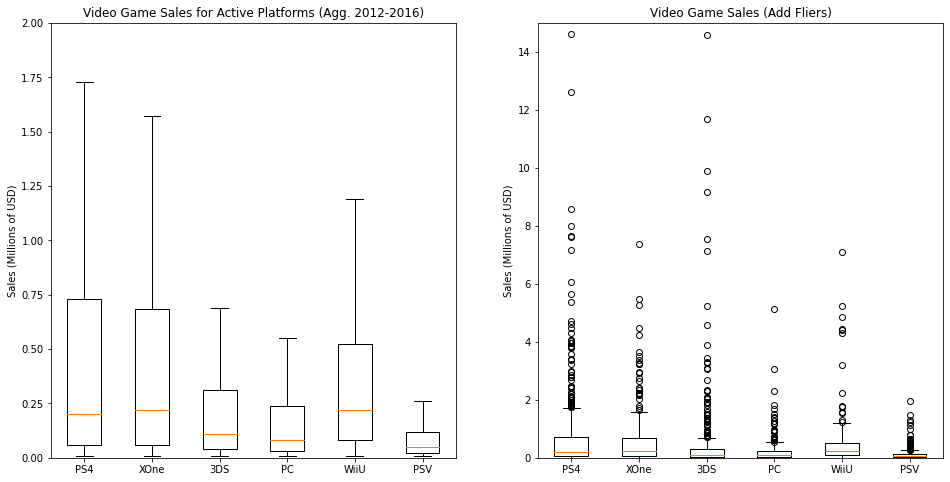

In [13]:
# Create boxplots for each platform
fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].clear()
axs[0].boxplot([df.query('platform == @k')['total_sales'] for k in top_2016_df['platform']],
           labels=top_2016_df['platform'],
           showfliers=False
          )
axs[0].set_ylim(0, 2)
axs[0].set_ylabel('Sales (Millions of USD)')
axs[0].set_title('Video Game Sales for Active Platforms (Agg. 2012-2016)')
axs[1].clear()
axs[1].boxplot([df.query('platform == @k')['total_sales'] for k in top_2016_df['platform']],
           labels=top_2016_df['platform'],
          )
axs[1].set_ylim(0, 15)
axs[1].set_ylabel('Sales (Millions of USD)')
axs[1].set_title('Video Game Sales (Add Fliers)')
plt.show()

Before we jump into analyzing these graphs, recall our life cycle performance metrics for these platforms:

In [14]:
# Refresher on the platform performance data in question 
display(top_2016_df)

,platform,intro_year,first_perc_year,peak_year,last_perc_year,unique_titles,total_sales
0,PS4,2013,2014,2015,2016,392,314.14
1,XOne,2013,2014,2015,2015,247,159.32
2,3DS,2011,2011,2011,2014,520,259.00
3,PC,2009,2010,2011,2012,974,259.52
4,WiiU,2012,2012,2014,2015,147,82.19
5,PSV,2011,2012,2012,2014,430,54.07


The average game released on any platform expects to get between 100,000USD or 250,000USD in sales. There are significant differences in the expected sales of a game by platform, but often this must be taken in conjunction with the size of the pool of games being sold to that market share. 

Looking at the first graph, for example, the average WiiU title performs very well. However, it is fighting for last place on our list for market share. This is primarily due to the low number of unique titles released relative to the rest of the platforms; even though the WiiU market share was about 1/4 the size of that of the PS4, there were also only 1/3 the number of titles. Therefore, each WiiU title performed well given that it had less internal competition in its own market share.

To take an opposite example, because indie games release on PC more than on any other console, there are a sky-high number of unique PC game titles. This drives down the mean PC sales value, and each PC title has to compete with a sea of titles in that market share. However, the mainstream PC games perform nearly as well as the PS4 and XOne titles. After all, the highest-grossing PC game in this dataset brought in more than the highest-grossing XBox game. Similarly, despite the average 3DS game grossing a little better than half what the average PS4 game will, the highest-grossing 3DS game is essentially tied with the highest-grossing PS4 game at nearly 15 million USD.

### Reviews and Sales

Sales may often depend on the perceived or actual quality of a game. We should look at the correlation between user/professional reviews and sales. To zoom in somewhat at the data, we'll look at one platform in particular -- PC.

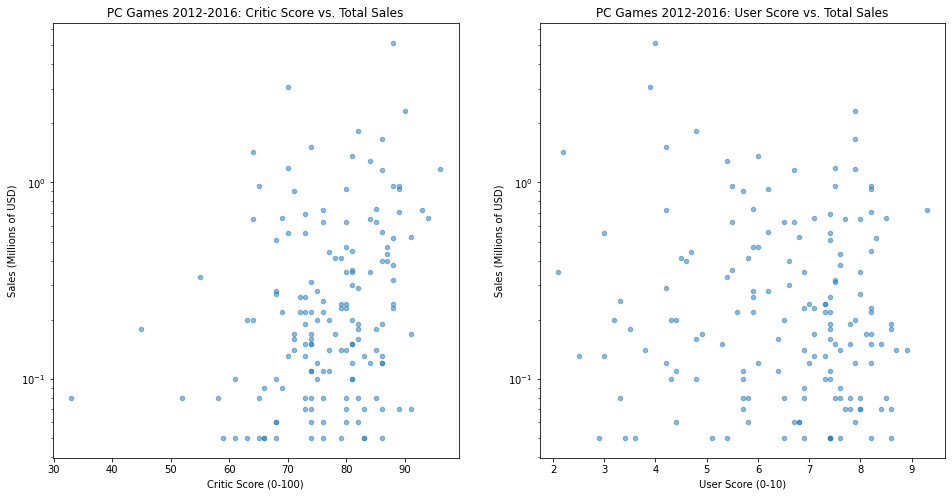

In [15]:
#For this section, isolate to PC games, and for visibility's sake, only to games which sold at least $50,000
pc_df = df[df['platform'] == 'PC'].query('total_sales >= .05')

fig, axs = plt.subplots(1, 2, figsize=(16,8))
pc_df.plot(
    x='critic_score', 
    y='total_sales', 
    kind='scatter', 
    ax=axs[0],
    alpha=0.5
)

# Log-scale to better see distribution at low end. Add labels
axs[0].set_yscale('log')
axs[0].set_title('PC Games 2012-2016: Critic Score vs. Total Sales')
axs[0].set_xlabel('Critic Score (0-100)')
axs[0].set_ylabel('Sales (Millions of USD)')

pc_df.plot(
    x='user_score', 
    y='total_sales', 
    kind='scatter', 
    ax=axs[1],
    alpha=0.5
)
# Log-scale to better see distribution at low end. Add labels
axs[1].set_yscale('log')
axs[1].set_title('PC Games 2012-2016: User Score vs. Total Sales')
axs[1].set_xlabel('User Score (0-10)')
axs[1].set_ylabel('Sales (Millions of USD)')
plt.show()

Mere appearance of these graphs will tell you there seems to be a moderate relationship between critic score and sales (but even then, there are plenty of titles selling well over 500,000 USD that have critic scores less than 70). Still, compared to the user score graph, critic scores seem an especially strong indicator. The user score graph is all over the place, as users are likely to upset the relationship of rating to sales because they are both (1) more apt to rebuke well-selling games and to champion under-selling games and (2) be more inelastic with their genre and franchise preferences regardless of individual game quality. 

Let's consider briefly the relationship in this data between user score and critic score:

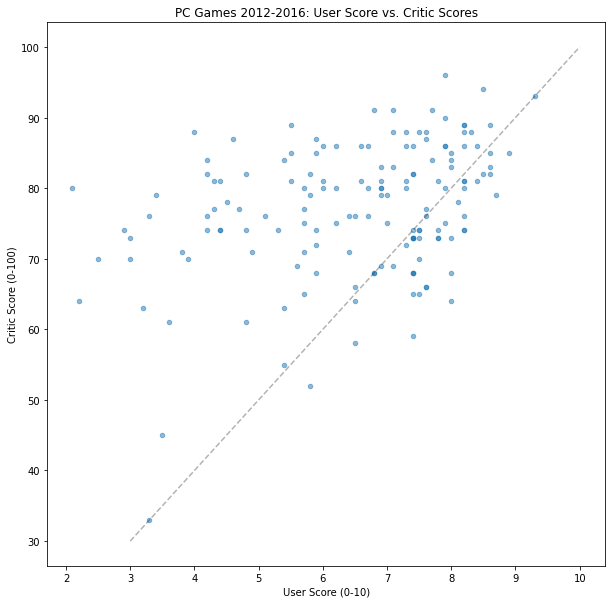

In [16]:
# Plot User Score v. Critic Scores
fig, ax = plt.subplots(figsize=(10,10))
pc_df.plot(
    x='user_score', 
    y='critic_score', 
    kind='scatter', 
    ax=ax,
    alpha=0.5
)
ax.plot([3, 10], [30, 100], 'k--', alpha=0.3)

# Add labels
ax.set_title('PC Games 2012-2016: User Score vs. Critic Scores')
ax.set_xlabel('User Score (0-10)')
ax.set_ylabel('Critic Score (0-100)')
plt.show()

In [17]:
# Correlate critic and user scores to sales
print('User score and total sales correlation:', pc_df['user_score'].corr(pc_df['total_sales']))
print('Critic score and total sales correlation:', pc_df['critic_score'].corr(pc_df['total_sales']))
print('')

# Correlate user score to critic score
print('User score and critic score correlation:', pc_df['user_score'].corr(pc_df['critic_score']))

User score and total sales correlation: -0.15101615671108942
Critic score and total sales correlation: 0.20235803018604168

User score and critic score correlation: 0.3516945066526508


It turns out that critics' tastes predict PC games sales far better than users' tastes. However, even then, they are only moderately correlated to the success of a game. The fact that user rating has functionally no statistical bearing on sales demonstrates their inelasticity and, likely, the power of advertising, as sales are more dependent on perceived quality of a game prior to buying.

The primary marketing conclusion is that critic reviews and scores should be included in advertising to boost the perceived quality of a game over user reviews and scores.

### A Brief Case Study of the Same Titles Across Platforms

Before moving on to genre, it is worth considering whether a title released on multiple platforms will do well. We will look only at games released on three or more total platforms.

In [18]:
'''
New dataframe for titles released on multiple platforms:
    'title': The published name of the game in question    
    'sales_ps4': The sales for the PS4 release of the game; NaN if no release for this platform
    'sales_xone': The sales for the XOne release of the game; NaN if no release for this platform
    'sales_3ds': The sales for the 3DS release of the game; NaN if no release for this platform
    'sales_pc': The sales for the PC release of the game; NaN if no release for this platform
    'sales_wiiu': The sales for the WiiU release of the game; NaN if no release for this platform
    'sales_psv': The sales for the PSV release of the game; NaN if no release for this platform
    'total_sales': The total sales across all platforms for this title
'''

# First, get all games that had releases on 3 or more platforms
six_platforms = top_2016_df['platform']
multiplatform_list = df.query('platform in @six_platforms').groupby('name', group_keys=False).apply(lambda x: x.iloc[0]['name'] if x['platform'].count() >= 3 else np.nan)
multiplatform_list = list(multiplatform_list[~multiplatform_list.isna()].reset_index(drop=True))

# Initialize column names and data array to concatenate rows before forming DataFrame for efficiency
cols = ['title', 'sales_ps4', 'sales_xone', 'sales_3ds', 'sales_pc', 'sales_wiiu', 'sales_psv']
data = []

# Accumulating function
def multiplatform_row(dframe, title):
    # Takes as input the dataframe to pull from and the title of the game
    #
    # Outputs a row list of the data
    game_df = dframe.query('name == @title')
    return [
        title, # title
        game_df.query('platform == "PS4"')['total_sales'].values[0] if game_df.query('platform == "PS4"')['total_sales'].count() > 0 else np.nan, # sales_ps4
        game_df.query('platform == "XOne"')['total_sales'].values[0] if game_df.query('platform == "XOne"')['total_sales'].count() > 0 else np.nan, # sales_xone
        game_df.query('platform == "3DS"')['total_sales'].values[0] if game_df.query('platform == "3DS"')['total_sales'].count() > 0 else np.nan, # sales_3ds
        game_df.query('platform == "PC"')['total_sales'].values[0] if game_df.query('platform == "PC"')['total_sales'].count() > 0 else np.nan, # sales_pc
        game_df.query('platform == "WiiU"')['total_sales'].values[0] if game_df.query('platform == "WiiU"')['total_sales'].count() > 0 else np.nan, # sales_wiiu
        game_df.query('platform == "PSV"')['total_sales'].values[0] if game_df.query('platform == "PSV"')['total_sales'].count() > 0 else np.nan # sales_psv
    ]

# Form the dataframe
for title in multiplatform_list:
    data.append(multiplatform_row(df, title))
multiplatform_df = pd.DataFrame(data, columns=cols)
multiplatform_df['total_sales'] = multiplatform_df.loc[:, cols[1:-1]].sum(axis=1, min_count=1)
display(multiplatform_df)

,title,sales_ps4,sales_xone,sales_3ds,sales_pc,sales_wiiu,sales_psv,total_sales
0,Adventure Time: Finn & Jake Investigations,0.10,0.05,0.09,NaN,0.05,NaN,0.29
1,Alien: Isolation,1.12,0.50,NaN,0.15,NaN,NaN,1.77
2,Angry Birds Star Wars,0.22,0.17,0.33,NaN,0.10,0.08,0.82
3,Assassin's Creed Chronicles,0.08,0.01,NaN,NaN,NaN,0.07,0.09
4,Assassin's Creed IV: Black Flag,2.86,2.24,NaN,0.65,0.29,NaN,6.04
...,...,...,...,...,...,...,...,...
144,Watch Dogs,4.05,1.57,NaN,0.44,0.13,NaN,6.19
145,Wolfenstein: The New Order,1.54,0.68,NaN,0.45,NaN,NaN,2.67
146,Wolfenstein: The Old Blood,0.43,0.15,NaN,0.08,NaN,NaN,0.66
147,XCOM 2,0.14,0.04,NaN,0.23,NaN,NaN,0.41


In [19]:
# Display correlation matrix to see how game sales for one platform correlate to sales on other platforms
print('Correlation of each sales type by each other sales type, including total sales:')
display(multiplatform_df.corr())
print('')

# We are also interested in how these platform sales individually tend to contribute to total sales. Divide by total sales
av_share_platform = multiplatform_df.loc[:, [
    'sales_ps4', 'sales_xone', 'sales_3ds', 'sales_pc', 'sales_wiiu', 'sales_psv'
    ]].div(multiplatform_df['total_sales'], axis=0).mean()

print('Average share of total sales for each column:')
display(av_share_platform)

Correlation of each sales type by each other sales type, including total sales:


,sales_ps4,sales_xone,sales_3ds,sales_pc,sales_wiiu,sales_psv,total_sales
sales_ps4,1.000000,0.954308,0.309430,0.234100,0.109476,0.739149,0.982226
sales_xone,0.954308,1.000000,0.492727,0.239882,0.163681,0.902941,0.971552
sales_3ds,0.309430,0.492727,1.000000,-0.123562,0.376802,0.401131,0.364028
sales_pc,0.234100,0.239882,-0.123562,1.000000,-0.087532,0.277086,0.371555
sales_wiiu,0.109476,0.163681,0.376802,-0.087532,1.000000,0.343072,0.304610
sales_psv,0.739149,0.902941,0.401131,0.277086,0.343072,1.000000,0.652524
total_sales,0.982226,0.971552,0.364028,0.371555,0.304610,0.652524,1.000000



Average share of total sales for each column:


sales_ps4     0.573124
sales_xone    0.259295
sales_3ds     0.348660
sales_pc      0.115752
sales_wiiu    0.288816
sales_psv     0.348958
dtype: float64

The most stark conclusion of the above correlation data is the linear relationship between three columns: PS4 sales, XOne sales, and total sales. When a game is released on multiple consoles, PS4 and XOne sales will share a similar relative proportion of the overall sales pie. Also, when a game is released on PS4, it is almost always released on XOne, and thus their sales are always correlated. These two together always dominate total sales. When the PS4 is included in a game's release, PS4 sales usually contribute about half of the sales for that game, and the XOne contributes about a quarter of the sales.

PC sales are the least correlated to the other platforms, harking back to the above conclusions that PC games involve a wide variety of game types and indie developers. When the average PC game is released on multiple platforms, it is hard to pinpoint the likely consoles it was also released on.

Finally, even though the overall market shares for WiiU and PSV are low compared to other platforms, they perform very well on multi-platform titles, capturing on average a third of sales each. The PSV is highly correlated to PS4 and XOne releases, and yet on average outperforms XOne on multi-platform titles, suggesting that if a game released on PS4 or XOne is simple enough to be rendered on a portable device like the PSV, people will find value in taking their game on the go with them, and thus often prefer to buy it on a PSV.

### Genre Sales Distribution

Total Video Game Market Share (Millions of USD) by Genre 2012-2016:


genre
Action          441.52
Shooter         304.80
Role-Playing    193.09
Sports          181.09
Misc             85.04
Platform         61.00
Racing           53.59
Fighting         44.49
Simulation       35.61
Adventure        29.52
Strategy         13.34
Puzzle            4.89
Name: total_sales, dtype: float64

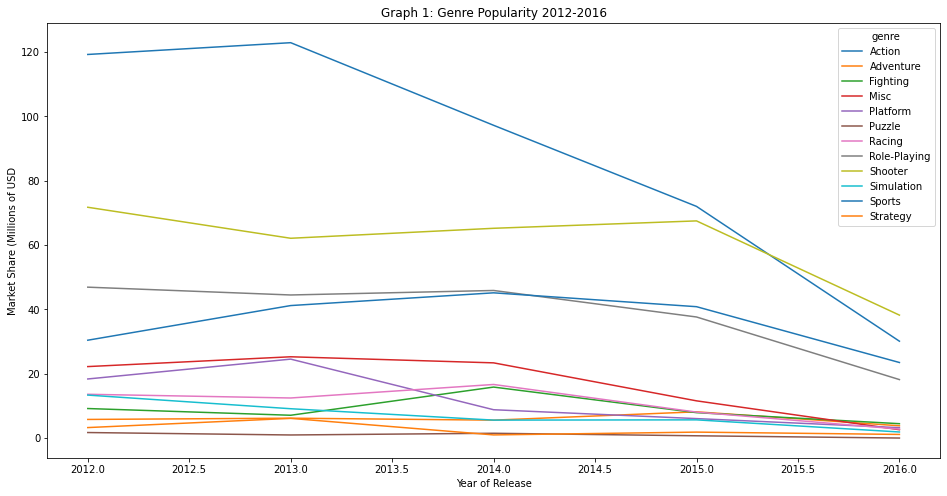

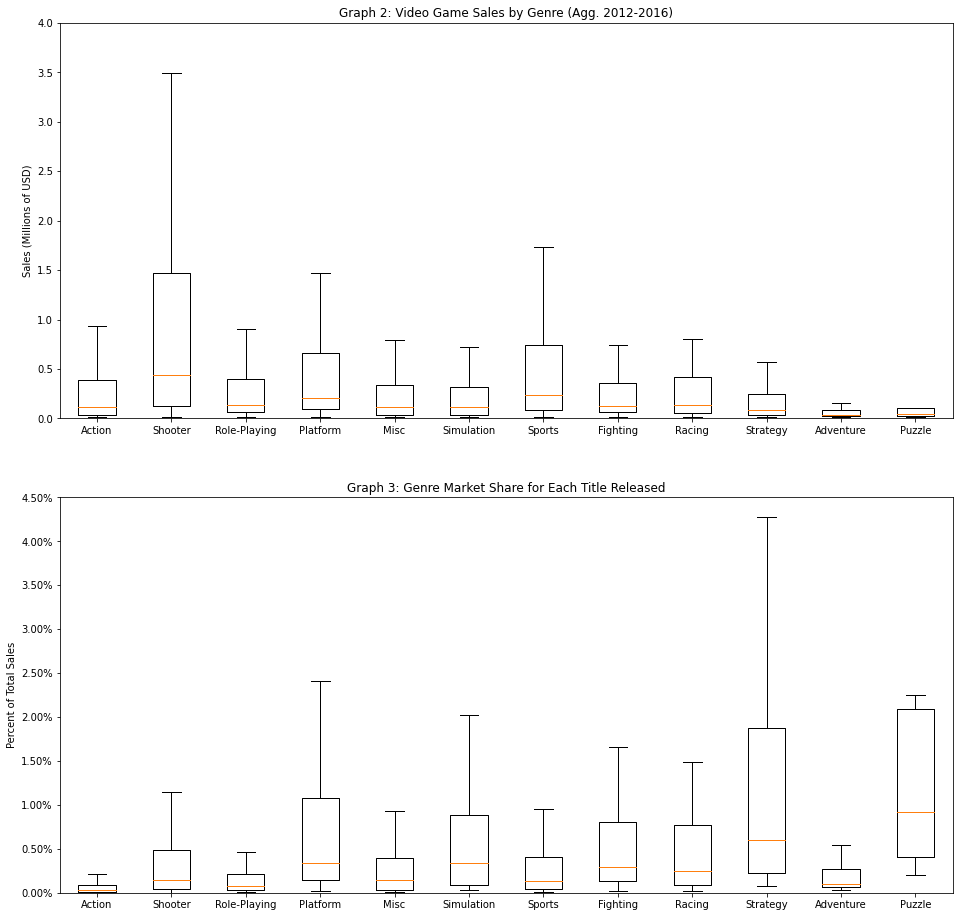

In [20]:
# Group by genre statistics and then by year
print('Total Video Game Market Share (Millions of USD) by Genre 2012-2016:')
display(df.groupby('genre')['total_sales'].sum().sort_values(ascending=False))
df.groupby(['year_of_release','genre'])['total_sales'].sum().unstack().plot(figsize=(16,8))
plt.title('Graph 1: Genre Popularity 2012-2016')
plt.ylabel('Market Share (Millions of USD')
plt.xlabel('Year of Release')
plt.show()

# Create boxplots for each genre
fig, axs = plt.subplots(2, 1, figsize=(16,16))
axs[0].clear()
axs[0].boxplot([df.query('genre == @k')['total_sales'] for k in list(df['genre'].unique())],
           labels=list(df['genre'].unique()),
           showfliers=False
          )
axs[0].set_ylim(0, 4)
axs[0].set_ylabel('Sales (Millions of USD)')
axs[0].set_title('Graph 2: Video Game Sales by Genre (Agg. 2012-2016)')
axs[1].clear()
axs[1].boxplot([100* df.query('genre == @k')['total_sales'].div(df.query('genre == @k')['total_sales'].sum().item()) for k in list(df['genre'].unique())],
           labels=list(df['genre'].unique()),
           showfliers=False
          )
axs[1].set_ylim(0, 4.5)
axs[1].yaxis.set_major_formatter(pf())
axs[1].set_ylabel('Percent of Total Sales')
axs[1].set_title('Graph 3: Genre Market Share for Each Title Released')
plt.show()

The top market shares for 2012-2016 are in Action, Shooter, Role-Playing, Sports, and Misc video games. We can see that the average title released in Action will perform moderately well in sales but still takes the smallest share of genre sales of any genre, averaging about 0.05% of its own genre sales. Inversely, the lowest market share holder, Puzzle games, boasts the highest per-title percentage of genre sales, averaging about 1% of its own genre sales. Much like a platform's performance is relative to the number of titles released on it, so too is a genre's performance relative to the number of titles released. Thus, we must balance our analysis: if a genre's overall market share has been performing well year-over-year (Graph 2 above) and the per-title genre share average is high (Graph 3 above), then it is worth marketing a new title in that genre.

This trend is especially clear in the profitability of Shooter games over Action games; while Action games have held a slight edge in overall market share, on a per-unit basis it is more profitable to generate and market a Shooter game. A Shooter game captures well over three times the share of its own genre's market share compared to an Action game's own genre market share, and thus we see the trend in Graph 2 -- a Shooter game is expected to sell on average at least three times as well.

Some genres are losing popularity, however, which is the final factor in the puzzle (Graph 1 above). The Misc and Platform genres had 80 million and 40 million USD in yearly sales in 2012 but by 2016 dropped to less than 10 million each, with no sign of improvement. These are not platforms worth advertising moving into 2017. Therefore, taking these out of the running, the most profitable genres to market are Shooter, Action, Fighting, Sports, and Racing.

## Region

The NA, EU, and JP markets represent unique sales regions, with varying user preferences in platforms and genres. We should look at the top five platforms and genres for each region, as well as consider the effect ESRB ratings have on regional sales.

### Top Platforms by Region

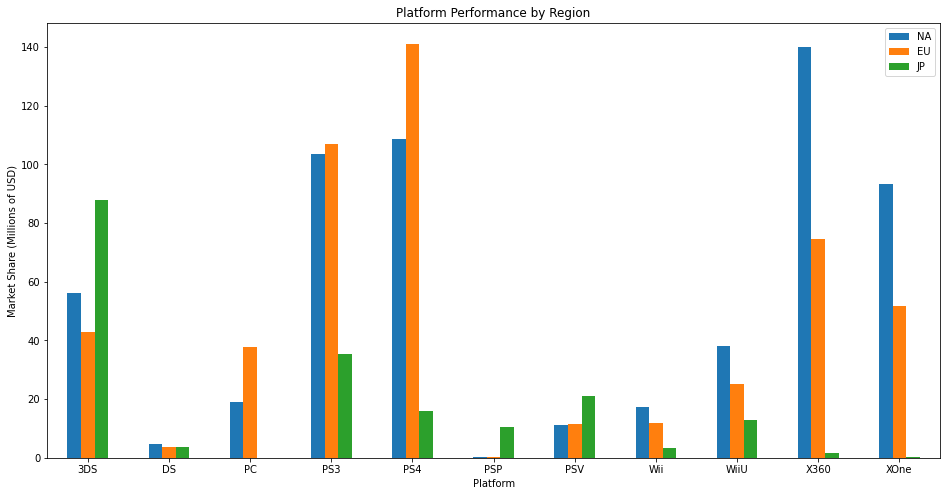

In [21]:
# Split by region and platform
df.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum().plot(
    kind='bar', 
    figsize=(16,8)
)
plt.legend(['NA', 'EU', 'JP'])
plt.title('Platform Performance by Region')
plt.ylabel('Market Share (Millions of USD)')
plt.xlabel('Platform')
plt.xticks(rotation=0)
plt.show()

The most popular NA and EU platforms from 2012-2016 were the X360, PS4, PS3, XOne, and 3DS. NA and EU consumers prefer devoted, stationary consoles which can play more robust and demanding games, with the only exception being the 3DS, which is handheld. It is worth noting that the large historic market for PC games is dominated by EU.

The most popular JP platforms from 2012-2016 were the 3DS, PS3, PSV, PS4, and WiiU. While stationary consoles like PS3 and PS4 still sell in JP, the standount market performances are for mobile, portable consoles, with three out of its five top platforms being smaller devices. It is the regional sales leader for the PSV, PSP, and 3DS markets, which is remarkable given its smaller population. The Japanese market share was less than 25 Million USD for the combined sales of titles for the otherwise-popular PS4, X360, PC, and XOne platforms.

### Top Genres by Region

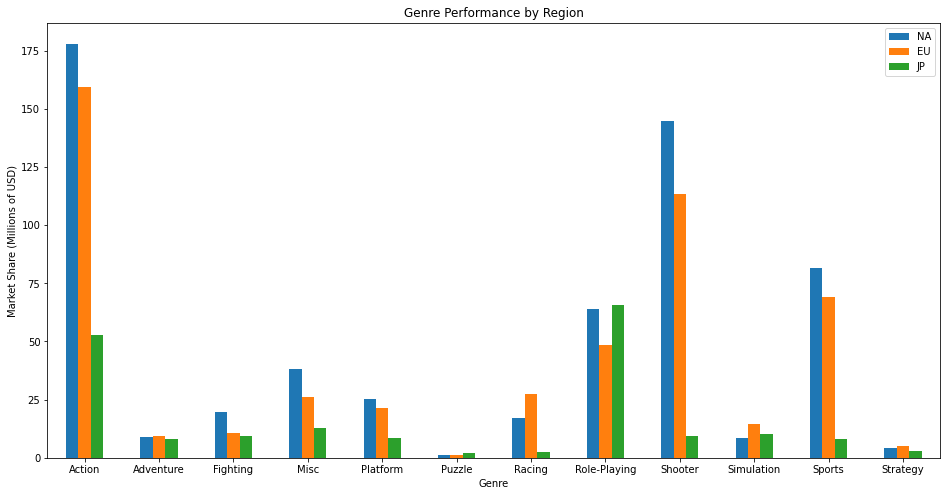

In [22]:
# Split by region and genre
df.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum().plot(
    kind='bar', 
    figsize=(16,8)
)
plt.legend(['NA', 'EU', 'JP'])
plt.title('Genre Performance by Region')
plt.ylabel('Market Share (Millions of USD)')
plt.xlabel('Genre')
plt.xticks(rotation=0)
plt.show()

The most popular NA and EU genres from 2012-2016 were, in order beginning with most popular: Action, Shooter, Sports, Role-Playing, and Misc/Racing (NA/EU respectively). These genres also reflect the overall most-popular genres worldwide during this period. NA was the regional sales leader in every major genre except Racing and Role-Playing, though for nearly all genres, EU sales only mildly or moderately lagged behind. 

The most popular JP genres from 2012-2016 were Role-Playing, Action, Misc, Fighting, and Simulation. Role-playing and Simulation were the only genres in which the JP market share beat the NA market share. JP is also notable in not caring much for the number two genre worldwide, Shooter, being beat out by EU and NA by almost 10-fold, or the number three genre worldwide, Sports, being beat out by the EU and NA by almost 6-fold.

### ESRB Ratings' Effect on Regional Sales

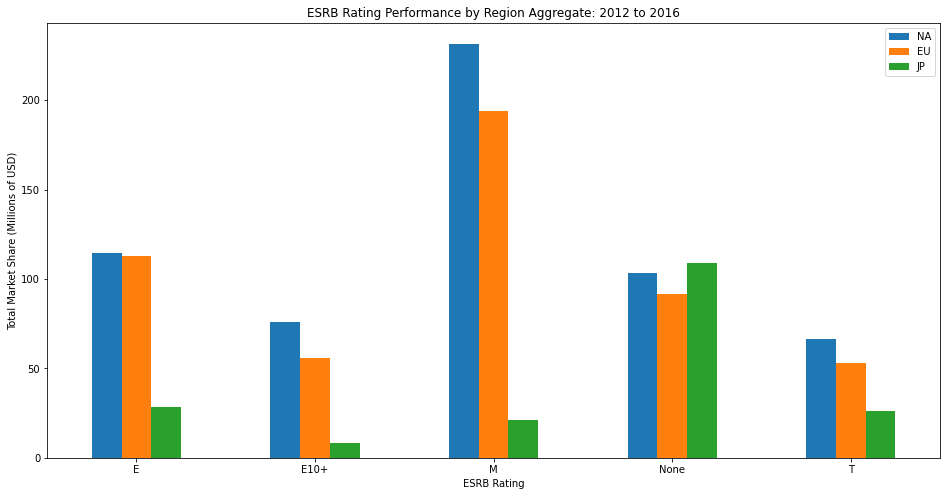

In [23]:
# Split by ESRB
df.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum().plot(
    kind='bar', 
    figsize=(16,8)
)
plt.legend(['NA', 'EU', 'JP'])
plt.title('ESRB Rating Performance by Region Aggregate: 2012 to 2016')
plt.ylabel('Total Market Share (Millions of USD)')
plt.xlabel('ESRB Rating')
plt.xticks(rotation=0)
plt.show()

In NA and EU, titles with an M (Mature) rating performed better than those rated T (Teen) or E (Everyone), while in JP, titles with an M rating performed worse than those rated T or E. Most notably, JP was the regional sales leader for those games which did not receive a rating, under "None," likely indicating the frequency of JP-only releases not being rated by the ESRB. In fact, when looking only at JP sales, sales for titles *without* a rating essentially beat out all other game sales combined.

Let us additionally look at the average sales for each rating, rather than the total, which might elucidate whether certain ratings on average perform better than others:

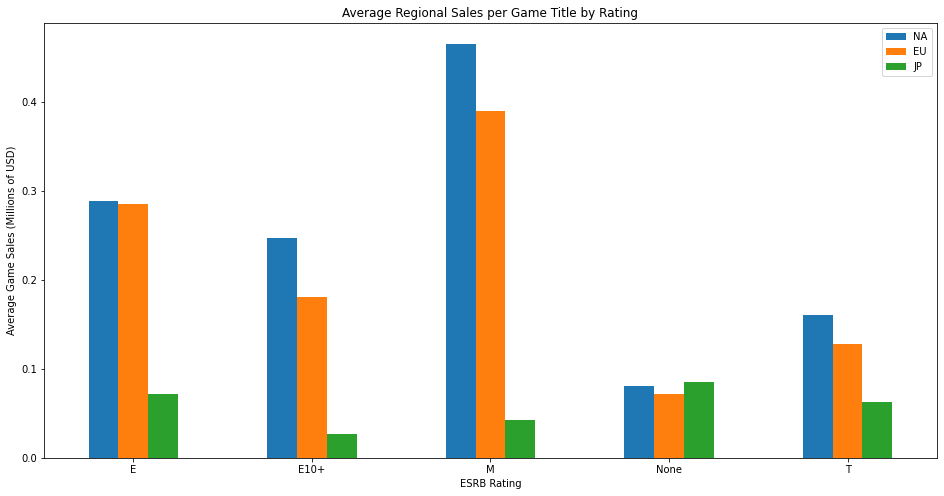

In [24]:
# Split by ESRB
df.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].mean().plot(
    kind='bar', 
    figsize=(16,8)
)
plt.legend(['NA', 'EU', 'JP'])
plt.title('Average Regional Sales per Game Title by Rating')
plt.ylabel('Average Game Sales (Millions of USD)')
plt.xlabel('ESRB Rating')
plt.xticks(rotation=0)
plt.show()

This graph now tells us that those games rated M perform over twice as well as any other rating, except in JP.

## User Rating Hypotheses

We would like to tie this analysis off with some statistical conclusions about how users view games of different platforms and genres.

These data points have a wide variability with thousands of data points, and as we saw above, user ratings were absent of any correlation to sales performance. Therefore, if we are to draw meaningful conclusions and extract patterns from this apparent chaos, we should set a very significant *alpha* threshold and be thorough in our hypotheses. We will use an *alpha* value of 0.01 for ALL hypotheses.

### XBox One vs PC Ratings

The first comparison we'll make is between XBox One and PC user ratings. We believe that games released on these two platforms have different user ratings, and so we will set the null hypothesis to "users rate PC games similarly to XBox One games" and the alternative hypothesis to "users rate PC games differently than XBox One games." We will assume the variance is different enough to merit setting `equal_var` to False, as these are separate user populations with little overlap.

In [25]:
alpha = 0.01  # Significance level set to high

# Two-sided t-test of two population means. Setting equal_var to False assuming different user populations
results = st.ttest_ind(df.query('platform == "PC"')['user_score'], df.query('platform == "XOne"')['user_score'], equal_var=False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.")

p-value:  0.2518232001572021
We can't reject the null hypothesis.


It appears platform of release alone is not a significant enough factor to influence user rating. 

However, to truly drive the point home, we will directly compare games released on both platforms to see if users on one platform preferred the game over users on the other platform. We believe that PC users score games lower than XBox One users due to a multitude of factors including portability to PC, cross-platform play, etc. Therefore, we will set the null hypothesis to "For any given game, the PC user score will be the same as or higher than the XBox One user score," and the alternative hypothesis to "For any given game, the PC user score will be lower than the XBox One user score." 

In [26]:
pc_df = df.query('platform == "PC"')
xone_df = df.query('platform == "XOne"')
merged_df = pc_df.merge(
    xone_df, 
    on='name',
    suffixes=['_pc', '_xone']
)

# Relational comparison of population samples for data with same length
results = st.ttest_rel(merged_df['user_score_pc'], merged_df['user_score_xone'])

print('p-value: ', results.pvalue)
display(merged_df[['user_score_pc', 'user_score_xone']].mean())

if (results.pvalue < alpha / 2) and (merged_df['user_score_pc'].mean() < merged_df['user_score_xone'].mean()):
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.")

p-value:  0.000144817683284263


user_score_pc      6.420952
user_score_xone    6.859048
dtype: float64

We reject the null hypothesis.


Now, unlike our general population analysis above, in our paired-sample analysis, we do have a significant p-value. Users rate the same game lower if played on PC than on XOne.

### Action vs. Sports Genre Ratings

The final comparison we'll make is between Action and Sports user ratings. We believe that games released on these two genres have different user ratings, and so we will set the null hypothesis to "users rate Action games similarly to Sports games" and the alternative hypothesis to "users rate Action games differently than Sports games." Because the same users may be making the same user ratings, variance has no reason to be different, and so we ignore the `equal_var` parameter.

In [27]:
# Two-sided t-test of two population means. Ignoring equal_var assuming similar user populations
results = st.ttest_ind(df.query('genre == "Action"')['user_score'], df.query('genre == "Sports"')['user_score'])

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.")

p-value:  1.1820137100801342e-39
We reject the null hypothesis.


These genres are rated statistically different.

## Conclusion

In the above analysis we isolated game sales data to 2012-2016 after a preliminary exploration of the data. We found that platforms and genre differ widely in general profitability but for the immediate future (2017) the top platforms to advertise are the PS4, XOne, WiiU, and PC, and the top genres to advertise are Shooter, Action, Fighting, Sports, and Racing. These top performers won out after taking into account a few factors, including relative market share and whether they were falling off in popularity. We found that Japan's market has different genre, ESRB rating, and platform preferences to the North America and European Union markets, preferring to play action-roleplaying games with unrated/teen ratings on more portable platforms. Finally, we found that critic scores were more correlated with the market success of a game, and users scored some genres over others, even preferring certain platforms over others for the same game title.